# Ungraded Lab: Training a Sarcasm Detection Model using a Convolution Layer

You will be doing the same steps here as the previous lab but will be using a convolution layer instead. As usual, try tweaking the parameters and observe how it affects the results.


In [1]:
import json
import matplotlib.pyplot as plt
import tensorflow as tf

## Load the Dataset

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
# !wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

In [3]:
# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Parameters

In [4]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Type of padding
PADDING_TYPE = 'pre'

# Specifies how to truncate the sequences
TRUNC_TYPE = 'post'

## Split the Dataset

In [5]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

## Data preprocessing

In [6]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Generate the vocabulary based on the training inputs
vectorize_layer.adapt(train_sentences)

In [7]:
# Preprocess the train and test data
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

In [8]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Apply the vectorization layer to the reviews
  dataset_sequences = dataset.map(lambda review, label: (vectorize_layer(review), label))

  # Put all elements in a single ragged batch
  dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())

  # Output a tensor from the single batch. Extract the sequences and labels.
  sequences, labels = dataset_sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), maxlen=MAX_LENGTH, truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  # Combine the padded sequences and labels
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [9]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

In [10]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Plot Utility

In [12]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

## Build and Compile the Model

In [13]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [14]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1749667775.283445    6847 service.cc:145] XLA service 0x7945f404b900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749667775.283489    6847 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6


158/625 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.5619 - loss: 0.6698

I0000 00:00:1749667776.795569    6847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6727 - loss: 0.5898 - val_accuracy: 0.8344 - val_loss: 0.4406
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8775 - loss: 0.3805 - val_accuracy: 0.8422 - val_loss: 0.4134
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9238 - loss: 0.2684 - val_accuracy: 0.8444 - val_loss: 0.4733
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9513 - loss: 0.1894 - val_accuracy: 0.8419 - val_loss: 0.4946
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9674 - loss: 0.1158 - val_accuracy: 0.8439 - val_loss: 0.5246
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9759 - loss: 0.0813 - val_accuracy: 0.8427 - val_loss: 0.6016
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9851 - loss: 0.0512 - val_accuracy: 0.8369 - val_loss: 0.7683
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9916 - loss: 0.0290 - val_accuracy: 0.8353 - val_

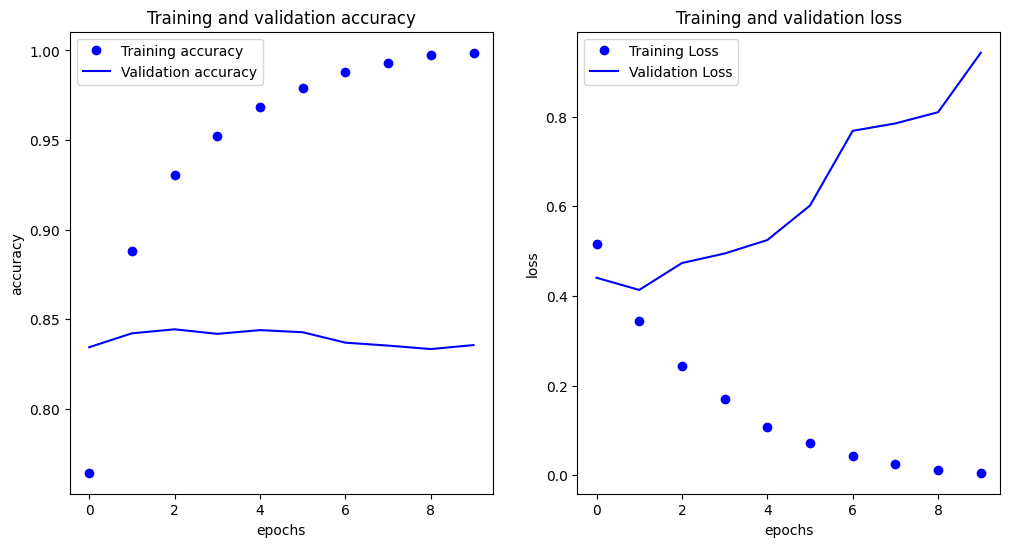

In [15]:
plot_loss_acc(history_conv)